In [1]:
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
from local_models.plotting_utils import mayavi_plt_pts
from local_models.tf_quadric_models import *
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import mayavi
import mayavi.mlab
import string
import subprocess
import functools
import cv2
import itertools
from local_models.quadric_models import *
from local_models.plotting_utils import *
from joblib import Parallel, delayed


#on headless systems, tmux: "Xvfb :1 -screen 0 1280x1024x24 -auth localhost", then "export DISPLAY=:1" in the jupyter tmux
mayavi.mlab.options.offscreen = True



logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
FRESH=True

In [3]:
kernel_names = {
    local_models.local_models.GaussianKernel: 'gaussian',
    local_models.local_models.TriCubeKernel: 'tricube'
}

In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
data_file = "/home/brown/Downloads/subject001/3d/andreadm2.stl"

In [6]:
import stl

tri_mesh = stl.mesh.Mesh.from_file(data_file).points.reshape(-1,3)

In [7]:
tri_mesh.shape

(346758, 3)

In [8]:
data, cts = np.unique(tri_mesh, axis=0, return_counts=True)

In [9]:
data.shape

(58659, 3)

In [10]:
(data.shape[0]*100)**(1/3)

180.348091843

In [11]:
np.mean(data, axis=0)

array([ -71.71989 , -340.46124 ,   31.036196], dtype=float32)

In [12]:
KERNEL=local_models.local_models.TriCubeKernel
RUN = 30

project_dir = "../data/tf_quadrics_{}_{:03d}".format(kernel_names[KERNEL], RUN)

os.makedirs(project_dir, exist_ok=1)

In [13]:
u = np.arange(9).reshape(3,3)
u += u.T
l, u = np.linalg.eig(u)

np.random.seed(0)
x = (np.random.uniform(size=(3000,3))-0.5)*10
imag_0tol=1e-2

In [14]:
q = np.array([ # an ellipsoid
    [0.5,0,0,0],
    [0,0.25,0,0],
    [0,0,0.1,-1],
    [0,0,-1,0.1],
])

E = np.block([[u, np.array([[1,2,3]]).T],[np.zeros(3), 1]])
Einv = np.linalg.inv(E)
q_test = Einv.T@q@Einv

planar_q = np.array([ # an elliptic paraboloid
    [0,0,0,1],
    [0,0,0,-2],
    [0,0,0,-1],
    [1,-2,-1,0.1],
])

In [30]:
some_q = np.array(
[[ 1.25731642e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,],
 [-2.12568175e-06,  1.28962719e-04,  0.00000000e+00,  0.00000000e+00,],
 [-2.31149213e-05, -1.14655018e-05,  5.33984569e-06,  0.00000000e+00,],
 [ 3.07163453e-04, -1.68037557e-04,  6.50044022e-01,  3.93554645e-01,]]
)

In [32]:
np.linalg.eigh(some_q[:3,:3])

(array([-6.53715364e-15,  1.30017103e-04,  1.30017103e-04]),
 array([[-0.18155096, -0.02280611,  0.98311705],
        [-0.09005321,  0.99591592,  0.006473  ],
        [-0.97924954, -0.08735767, -0.18286326]]))

In [15]:
with tf.Graph().as_default(), tf.Session() as sess:
    test_qs = tf.placeholder(tf.float32, q.shape)
    test_pts = tf.placeholder(tf.float32, x.shape)
    test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
    test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    proj1_pts, proj1_dists = tf_ortho_project(test_qsc, test_ptsc,imag_0tol=imag_0tol)
    proj1_ptsc = tf.cast(proj1_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
    proj2_pts, proj2_dists = tf_ortho_project(test_qsc, proj1_ptsc,imag_0tol=imag_0tol)
    p1p, p2p, p1d, p2d = sess.run([proj1_pts, proj2_pts, proj1_dists, proj2_dists], feed_dict={test_pts: x, test_qs: q_test})

Q Tensor("Cast:0", shape=(4, 4), dtype=complex64)
Tensor("transpose:0", shape=(3, 3), dtype=complex64)
Tensor("matmul_1:0", shape=(3000, 3), dtype=complex64)
Tensor("matmul_2:0", shape=(1, 3), dtype=complex64)
L,U,UL,UR,BR Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("SelfAdjointEigV2:1", shape=(3, 3), dtype=complex64) Tensor("SelfAdjointEigV2:0", shape=(3,), dtype=complex64) Tensor("add:0", shape=(3000, 3), dtype=complex64) Tensor("add_2:0", shape=(3000, 1), dtype=complex64)
args0 Tensor("strided_slice_5:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args1 Tensor("strided_slice_6:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args2 Tensor("strided_slice_7:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args3 Tensor("strided_slice_8:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args4 Tensor("strided_slice_9:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args5 Tensor("strided_slice_10:0", shape=(3000, 1), dtype=complex64)
(3000, 1)
args6 Tensor("strided_slice_11

In [16]:
tp1p, tp1d = orthogonal_quadric_projection(x,q_test,projection_funcs)
tp2p, tp2d = orthogonal_quadric_projection(tp1p,q_test,projection_funcs)

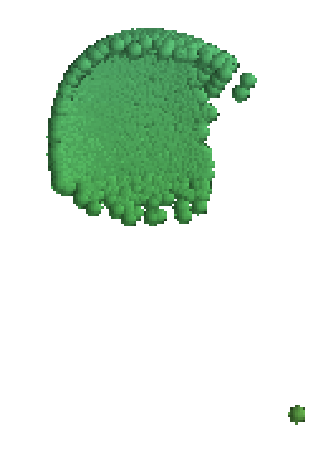

In [17]:
mayavi_plt_pts(p1p, dist=10*np.std(x, axis=0))

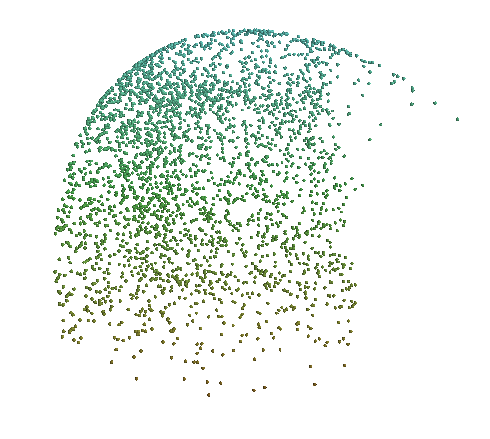

In [18]:
mayavi_plt_pts(tp1p, dist=np.std(x, axis=0))

[3.89564240e-12 5.52745208e-13 1.31678818e-12 ... 1.25803358e-12
 1.94945665e-11 1.59016915e-11]


(array([2.999e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.30076811e-16, 3.83132126e+01, 7.66264252e+01, 1.14939638e+02,
        1.53252850e+02, 1.91566063e+02, 2.29879276e+02, 2.68192488e+02,
        3.06505701e+02, 3.44818913e+02, 3.83132126e+02]),
 <a list of 10 Patch objects>)

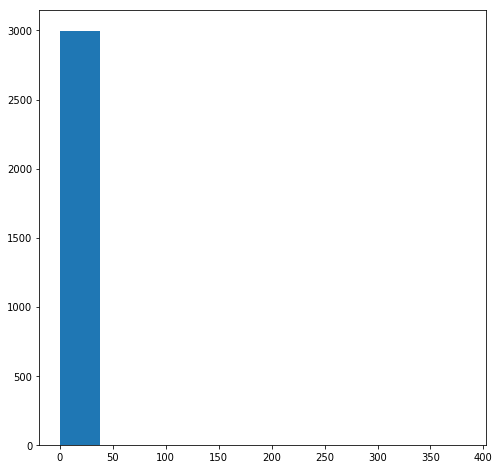

In [19]:
print(np.sum((p1p-tp1p)**2, axis=1))
plt.hist(np.sum((p1p-tp1p)**2, axis=1))

In [20]:
with fuckit("nothing to del"):
    del TFQuadricSesh 
with fuckit("nothing to del"):
    del TFQuadricGraph 
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricSesh
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricGraph

nothing to del
nothing to del
nothing to del
nothing to del


In [21]:
with fuckit("they don't exist"): 
    print(TFQuadricSesh.graph, TFQuadricGraph, len(TFQuadricSesh.graph.get_operations()))

they don't exist


In [22]:
with fuckit("no sess to close"): 
    tfmodel.sess.close()

no sess to close


In [24]:
tfmodel = TFParabolic(n_epochs=5000, log_epochs=True, weighted=False, 
    parabolic_constraint=True, learning_rate=0.02, loss_trim=0.95)

building!
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(3, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 3), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_2:0", shape=(3, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(3,), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_2:0", shape=(?, 3), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_4:0", shape=(?, 1), dtype=complex128)
args0 Tensor("quadric_regression/quadric_projection/cond/strided_slice_2:0", shape=(?, 1), dtype=complex128)
(?, 1)
args1 Tensor("quadric_regression/quadric_projection/cond/strided_slice_3:0", shape=(?, 1), dtype=complex128)
(?, 1)
args2 Tensor("quad

special_pts Tensor("quadric_regression/quadric_projection/cond_1/Merge:0", shape=(?, 3), dtype=complex128)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/GatherV2_1:0", shape=(3,), dtype=float64)
Tensor("quadric_regression/training/optimizer/update_quadric_regression/quadric_projection/flattened_quadric/parabolic_constraint/concat_3:0", shape=(3,), dtype=float64)
(4, 4)


In [25]:
tfmodel.fit(tp1p, 
    #beta0 = (q_test / np.linalg.norm(q_test))[np.triu_indices(4)]
)

TFParabolic(batch_size=None, input_shape=3, learning_rate=0.02, log_epochs=True,
            loss_trim=0.95,
            model=<ml_battery.tensorflow_models.NameSpace object at 0x7f5a7c2758d0>,
            n_epochs=5000, normalize_weights=True, parabolic_constraint=None,
            projection_funcs=({'k_mat': <function k_mat0_3 at 0x7f5a91cc9bf8>,
                               'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f5a91cc98c8>, 3, 0, other_dims_func=<function other_dims_as_x0_3 at 0x7f5a91cc9a60>)},
                              {'k_mat': <function k_mat1_3 at 0x7f5a91cc9c80>,
                               'other_dims_as_x': functools.partial(<function munge_other_dims at 0x7f5a91cc98c8>, 3, 1, other_dims_func=<function other_dims_as_x1_3 at 0x7f5a91cc9ae8>)}),
            trainable=True, weighted=False)

In [26]:
def project_and_tf_plt(x, q, pth, additional_pts=[], colormaps=None):
    import tensorflow as tf
    import tf_roots
    import quadrics_utils

    projection_funcs = {
        "k_mat": quadrics_utils.k_mat,
        "other_dims_as_x": lambda a,b,c,d,e,f,g,x: [quadrics_utils.y_as_x(a,b,c,d,e,f,g,x), quadrics_utils.z_as_x(a,b,c,d,e,f,g,x)],
    }
    with tf.Graph().as_default(), tf.Session() as sess:
        test_qs = tf.placeholder(tf.float32, q.shape)
        test_pts = tf.placeholder(tf.float32, x.shape)
        test_qsc = tf.cast(test_qs, tf.complex128 if test_qs.dtype == tf.float64 else tf.complex64)
        test_ptsc = tf.cast(test_pts, tf.complex128 if test_pts.dtype == tf.float64 else tf.complex64)
        tf_projected_pts, _ = tf_ortho_project(test_qsc, test_pts)
        projected_pts = sess.run(tf_projected_pts, feed_dict={test_qs:q, test_pts:x})
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), False, colormaps=colormaps)

In [27]:
def project_and_plt(x, q, pth, additional_pts=[], colormaps=None):
    projected_pts, _ = orthogonal_quadric_projection(x,q,projection_funcs)
    mayavi_plt_pts([projected_pts]+additional_pts, pth, False, 
        np.average(x,axis=0), np.std(x,axis=0), 
        #None, None,
        False, colormaps=colormaps)

In [28]:
def fq2q(fq,input_shape=3):
    return fq + fq.T - np.diag(fq[np.diag_indices(input_shape+1)])

In [29]:
the_qs = list(map(fq2q, tfmodel.fitted_qs))

AttributeError: 'TFParabolic' object has no attribute 'fitted_qs'

In [ ]:
plotted = Parallel(n_jobs=4, verbose=10)(delayed(project_and_plt)(v,w,y,z,c) for v,w,y,z,c in 
    zip(
        [tp1p]*len(the_qs), 
        the_qs,
        [os.path.join(project_dir, "local_quadric_training_tp1p_{:05d}.png".format(i)) for i in range(len(tfmodel.fitted_qs))],
        [[tp1p]]*len(the_qs),
        [['gist_earth','black-white']]*len(the_qs),
    )
)

In [ ]:
plotted = Parallel(n_jobs=4, verbose=10)(delayed(project_and_plt)(v,w,y,z,c) for v,w,y,z,c in 
    zip(
        [x]*len(the_qs), 
        the_qs,
        [os.path.join(project_dir, "local_quadric_training_{:05d}.png".format(i)) for i in range(len(the_qs))],
        [[tp1p]]*len(the_qs),
        [['gist_earth','black-white']]*len(the_qs),
    )
)

In [93]:
K=2
n = 200
noise=.06
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.TriCubeKernel
noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=noise)

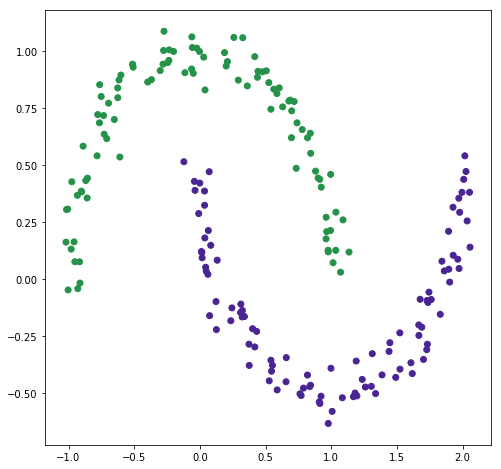

In [94]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))

In [95]:
regular_parabolic_projection_funcs_2, special_parabolic_projection_funcs_2 = arrange_parabolic_projection_funcs(2)

In [96]:
import importlib
importlib.reload(local_models.local_models)
importlib.reload(ml_battery.tensorflow_models)

<module 'ml_battery.tensorflow_models' from '/home/brown/python_packages/ml_battery/ml_battery/tensorflow_models.py'>

In [97]:
with fuckit("nothing to del"):
    TFQuadricSesh.close()
with fuckit("nothing to del"):
    del TFQuadricSesh 
with fuckit("nothing to del"):
    del TFQuadricGraph 
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricSesh
with fuckit("nothing to del"):
    del local_models.tf_quadric_models.TFQuadricGraph

nothing to del
nothing to del
nothing to del
nothing to del
nothing to del


In [98]:
parabolic_model = TFParabolic(n_epochs=500, log_epochs=False, weighted=True, parabolic_constraint=True, 
    learning_rate=0.05, input_shape=2,
    projection_funcs = (regular_parabolic_projection_funcs_2, special_parabolic_projection_funcs_2))
parabolic_model = TFParabolic(n_epochs=500, log_epochs=False, weighted=True, parabolic_constraint=True, 
    learning_rate=0.05, input_shape=2,
    projection_funcs = (regular_parabolic_projection_funcs_2, special_parabolic_projection_funcs_2),
    model = parabolic_model.model)
local_quadrics = local_models.local_models.LocalModels(parabolic_model)
#local_quadrics.fit(noisy_moons)

building!
Tensor("quadric_regression/quadric_projection/transpose_1:0", shape=(2, 2), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_1:0", shape=(?, 2), dtype=complex128)
Tensor("quadric_regression/quadric_projection/matmul_2:0", shape=(1, 2), dtype=complex128)
L,U,UL,UR,BR Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(2,), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_2:0", shape=(2, 2), dtype=complex128) Tensor("quadric_regression/quadric_projection/GatherV2_1:0", shape=(2,), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_2:0", shape=(?, 2), dtype=complex128) Tensor("quadric_regression/quadric_projection/add_4:0", shape=(?, 1), dtype=complex128)
args0 Tensor("quadric_regression/quadric_projection/cond/strided_slice_2:0", shape=(?, 1), dtype=complex128)
(?, 1)
args1 Tensor("quadric_regression/quadric_projection/cond/strided_slice_3:0", shape=(?, 1), dtype=complex128)
(?, 1)
args2 Tensor("quad

In [99]:
parabolic_model.model.grads

[(<tf.Tensor 'quadric_regression/training/gradients/quadric_regression/quadric_projection/map/while/strided_slice/Enter_grad/b_acc_3:0' shape=(6,) dtype=float64>,
  <tf.Variable 'quadric_regression/quadric_projection/flattened_quadric:0' shape=(6,) dtype=float64_ref>)]

In [100]:
avg_pt_dist = np.average(local_quadrics.index.query(noisy_moons, k=2)[0][:,1])

AttributeError: 'LocalModels' object has no attribute 'index'

In [101]:
avg_pt_dist

0.04519476350779057

In [102]:
bandwidth = avg_pt_dist*8
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth="knn", k=20)

In [103]:
def flatq2q(fq, input_shape=3):
    q = np.zeros((input_shape+1,input_shape+1))
    q[np.triu_indices(input_shape+1)] = fq
    q = q + q.T - np.diag(q[np.diag_indices(input_shape+1)])
    return q

In [153]:
def local_odq_shift(quadric_models, data, iterations=100, kernel=None, batch_size=100):
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iterations, tag="local_odq_shift")

    yield data
    for i in range(iterations):
        print(i)
        with timelog:
            if hasattr(kernel.bandwidth, "__call__"):
                data = quadric_models.predict(data,
                    k=kernel.k, weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size, parallel=True)
            else:
                data = quadric_models.predict(data,
                    r=kernel.support_radius(), weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size, parallel=True)
            yield data


In [154]:
def local_odq_shift_unfitted(unfitted_quadric_models, fit_data, predict_data, 
    iterations=100, kernel=None, batch_size=None):
    
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iterations, tag="local_odq_shift")

    if batch_size is None:
        batch_size = predict_data.shape[0]

    fitted_quadric_models = unfitted_quadric_models.fit(fit_data)
    iterated_predictions = [predict_data]
    for i in range(iterations):
        with timelog:
            if hasattr(kernel.bandwidth, "__call__"):
                predict_data = fitted_quadric_models.predict(predict_data,
                    k=kernel.k, weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size)
            else:
                predict_data = quadric_models.predict(data,
                    r=kernel.support_radius(), weighted=True, kernel=kernel,
                    neighbor_beta0s=False, batch_size=batch_size)
            iterated_predictions.append(predict_data)
    # returns data in [n_pts, n_features, n_iterations] shape
    return np.stack(iterated_predictions, axis=-1)

In [155]:
import joblib

In [159]:
def local_odq_shift_parallel(unfitted_quadric_models, fit_data, predict_data, 
    iterations=100, kernel=None, batch_size=100, n_jobs=32):
    
    base_batch = np.array([0,batch_size])
    n_batches = predict_data.shape[0]/batch_size

    slicers = [slice(*(base_batch + batch_size*n)) for n in range(int(n_batches))]

    iterated_predictionses = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(local_odq_shift_unfitted)(
                unfitted_quadric_models,
                fit_data,
                predict_data[slicer],
                iterations=iterations,
                kernel=kernel
            )
            for slicer in slicers
        )
    all_predictions = np.concatenate(iterated_predictionses, axis=0)
    return all_predictions


In [160]:
moon_x = local_models.utils.get_global_grid(noisy_moons, outside_range_pct=0.1, n_steps=2**6)
moon_x = local_models.utils.Grid2Vec().fit_transform(moon_x)

In [ ]:
odq_shift_iterations = local_odq_shift_parallel(local_quadrics, noisy_moons, moon_x, 
    iterations=20, kernel=lm_kernel, batch_size=2**7)

In [162]:
odq_shift_iterations.shape

(4096, 2, 21)

In [163]:
import local_models.linear_projections
import local_models.utils

def animate(data, c, iterations, pth, range_pct=0.1):
    data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
    graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)

    for i,projections in enumerate(iterations):
        figure = plt.figure()
        plt.scatter(data[:,0], data[:,1],c=cmap(c))
        plt.scatter(projections[:,0], projections[:,1],c='r',s=0.1)
        plt.title("iteration_{:05d}".format(i))
        plt.xlim(graph_bounds[:,0])
        plt.ylim(graph_bounds[:,1])
        plt.savefig(os.path.join(pth, "iteration_{:05d}.png".format(i)))


In [164]:
moons_dir = os.path.join(project_dir, "moon_iterations_parallel")
os.makedirs(moons_dir, exist_ok=1)

In [165]:
odq_shift_iterations.transpose(2,0,1).shape

(21, 4096, 2)

In [166]:
%%capture
animate(noisy_moons, c, odq_shift_iterations.transpose(2,0,1), moons_dir)

In [148]:
moons_dir

'../data/tf_quadrics_tricube_029/moon_iterations_parallel'

In [1517]:
the_qs[0]

array([[ 0.27613659, -0.17574578,  0.10128842],
       [-0.17574578,  0.11185254,  0.3299094 ],
       [ 0.10128842,  0.3299094 , -0.78183458]])

In [499]:
def np_arrange_parabolic_projection_funcs(n):
    import importlib
    import subprocess
    try:
        importlib.import_module("parabolic_utils_{}".format(n))
    except ImportError:
        subprocess.call(["python3","-m","local_models.quadric_models","--parabolic","{}".format(n)])
    projection_funcs = importlib.import_module("parabolic_utils_{}".format(n))
    parabolic_projection_funcs = {
        "k_mat": getattr(projection_funcs, "k_mat0_{}".format(n)),
        "other_dims_as_x": getattr(projection_funcs, "other_dims_as_x0_{}".format(n))
    }
    return parabolic_projection_funcs

In [500]:
def np_arrange_quadric_projection_funcs(n):
    import importlib
    import subprocess
    projection_funcs = importlib.import_module("local_models.quadrics_utils_{}".format(n))
    quadric_projection_funcs = {
        "k_mat": getattr(projection_funcs, "k_mat_{}".format(n)),
        "other_dims_as_x": getattr(projection_funcs, "other_dims_as_x_{}".format(n))
    }
    return quadric_projection_funcs

In [501]:
new_moons = []
for i, pt in enumerate(noisy_moons):
    print(i)
    new_pt, _ = orthogonal_quadric_projection(noisy_moons[i:i+1], the_qs[i],projection_funcs=np_arrange_quadric_projection_funcs(2))
    new_moons.append(new_pt)
new_moons = np.array(new_moons)[:,0,:]

0


NameError: name 'the_qs' is not defined

In [1537]:
new_moons.shape

(200, 2)

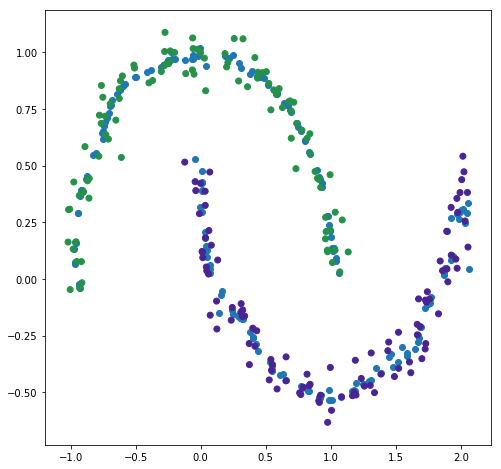

In [1541]:
plt.scatter(new_moons[:,0], new_moons[:,1])
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))

In [229]:
tuple(map(lambda x: np.sum(the_losses > x), 10.**np.arange(-5,6)))

(2961, 2961, 2961, 2957, 2788, 1980, 1187, 726, 211, 4, 4)

In [230]:
np.sum(the_losses > 0.1), np.sum(the_losses > 1), np.sum(the_losses > 10), np.sum(the_losses > 100)

(2788, 1980, 1187, 726)

In [231]:
np.sum(np.isnan(the_losses))

39

In [232]:
good_final_loss_mask = (~np.isnan(the_losses) & (the_losses < 1))

In [233]:
good_final_loss_models = [stuff[1][i] for i in range(good_final_loss_mask.shape[0]) if good_final_loss_mask[i]]

In [234]:
good_final_loss_models_pts = list(map(lambda y: y.predict(x), good_final_loss_models))

In [235]:
good_final_loss_models_centers = list(map(
    lambda i: good_final_loss_models[i].predict(elliptic_pts[good_final_loss_mask][i:i+1]), 
    range(len(good_final_loss_models))))

In [236]:
np.array(good_final_loss_models_centers).shape

(981, 1, 3)

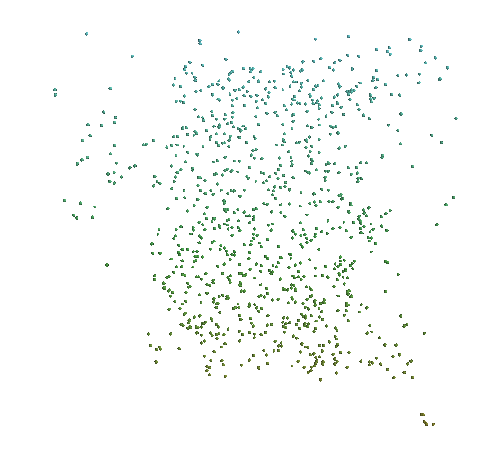

In [237]:
mayavi_plt_pts(np.array(good_final_loss_models_centers)[:,0,:],focus=np.average(elliptic_pts, axis=0),dist=np.std(elliptic_pts, axis=0))

In [238]:
from joblib import Parallel, delayed
plotted = Parallel(n_jobs=8, verbose=10)(delayed(mayavi_plt_pts)(v,w,x,y,z) for v,w,x,y,z in 
    zip(
        good_final_loss_models_pts, 
        [os.path.join(project_dir, "local_surfaces_{:05d}.png".format(i)) for i in range(len(good_final_loss_models_pts))],
        [False]*len(good_final_loss_models_pts),
        [np.average(elliptic_pts, axis=0)]*len(good_final_loss_models_pts),
        [np.std(elliptic_pts, axis=0)]*len(good_final_loss_models_pts)
    )
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    8.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   21.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   32.8s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   36.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   40.0s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   50.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(

In [ ]:
linear_models = local_models.local_models.LocalModels(local_models.TLS_models.LinearODR_mD(2))
linear_models.fit(data)

In [61]:
avg_pt_dist = np.average(linear_models.index.query(data, k=2)[0][:,1])

In [62]:
avg_pt_dist

1.2836044940342985

In [63]:
random_data_subset = data[np.random.randint(data.shape[0], size=50)]

In [64]:
queried = linear_models.index.query_radius(random_data_subset, r=avg_pt_dist*10)

In [65]:
list(map(lambda x: x.shape, queried))

[(289,),
 (315,),
 (283,),
 (386,),
 (209,),
 (106,),
 (375,),
 (321,),
 (405,),
 (372,),
 (341,),
 (352,),
 (376,),
 (308,),
 (249,),
 (347,),
 (245,),
 (380,),
 (378,),
 (414,),
 (419,),
 (106,),
 (345,),
 (320,),
 (444,),
 (282,),
 (208,),
 (371,),
 (368,),
 (423,),
 (307,),
 (435,),
 (374,),
 (324,),
 (271,),
 (147,),
 (150,),
 (147,),
 (397,),
 (318,),
 (407,),
 (200,),
 (239,),
 (403,),
 (401,),
 (316,),
 (353,),
 (321,),
 (261,),
 (289,)]

In [66]:
kernel = local_models.local_models.TriCubeKernel(bandwidth=avg_pt_dist*10)

In [67]:
linear_params_vecs, linear_params_mean = local_models.linear_projections.transformate_data(data, kernel, linear_models, r=kernel.support_radius())

In [68]:
linear_params_vecs.shape

(58659, 2, 3)

In [83]:
N = int(data.shape[0]/10)
sample_indices = np.random.choice(np.arange(data.shape[0]), size=N)

pth = os.path.join(project_dir, "single_convergence.png")
data_avg = np.average(data, axis=0)
data_std = np.std(data, axis=0)
figure = mayavi.mlab.figure(figure=None, bgcolor=(1,1,1), fgcolor=(0,0,0), engine=None, size=(1000, 500))
data_nodes = plt_data(figure, linear_params_mean[sample_indices], data_std)
normals = np.cross(*np.rollaxis(linear_params_vecs[sample_indices],1))
#normal_vecs = plt_normals(figure, normals, linear_params_mean[sample_indices], data_std)
#neg_normal_vecs = plt_normals(figure, -normals, linear_params_mean[sample_indices], data_std)
normalize_view(figure, data_avg, data_std, azimuth=40, elevation=80)
mayavi.mlab.savefig(pth, magnification=2)
mayavi.mlab.close(figure)

(-0.5, 1999.5, 999.5, -0.5)

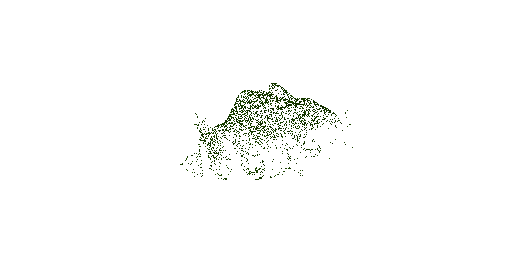

In [105]:
imshow(pth)
plt.axis("off")

In [84]:
global_linear_model = local_models.TLS_models.LinearODR_mD(2)
global_linear_model.fit(data)

In [87]:
global_linear_model.coef_
global_params_vecs = global_linear_model.coef_.reshape(2,-1)
global_params_mean = global_linear_model.intercept_
global_normal = np.cross(*global_params_vecs)

In [94]:
basis_changer = np.concatenate((global_params_vecs, global_normal.reshape(1,-1)),axis=0).T
basis_changer = np.linalg.inv(basis_changer)

In [95]:
bases_changed = np.einsum('ij,kj->ki', basis_changer, data-global_params_mean)

In [98]:
x,y,z = bases_changed.T

(-187.9690848273605,
 160.5978956286218,
 -131.18478754473625,
 174.82998666860883)

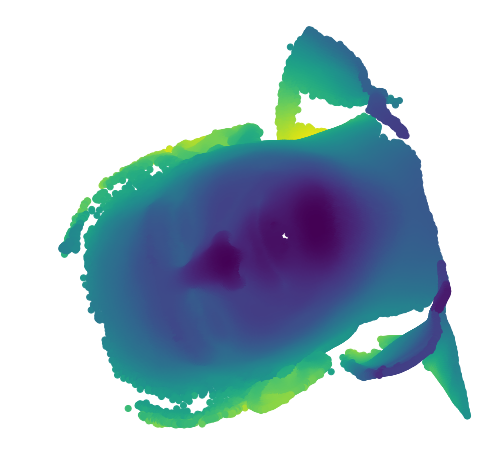

In [106]:
plt.scatter(x,y,c=z)
plt.axis("off")